# Orienteering

## DEFINIZIONE
Il problema dell'Orienteering è una variante del classico problema del commesso viaggiatore.
Il TSP classico prevede un grafo $G(V,A)$ a cui è associato un costo $d_{ij}$ ad ogni arco $(i,j) \in A$. L'obiettivo è tradizionalmente quello di trovare il circuito hamiltoniano (un ciclo che attraversa tutti i nodi del grafo una ed una sola volta) a costo minimo.

L'ORIENTEERING nasce come uno sport da fare in luoghi aperti come montagne o aree con foreste particolarmente fitte. I partecipanti partono da un punto e devono visitare quanti più control point possibili in un tempo limitato per poi tornare al control point specificato (spesso quello iniziale).

Le differenze rispetto al TSP tradizionale, quindi, sono:
-   Ad ogni punto di controllo vengono assegnati dei punti (nel codice sono assegnati in modo casuale)
-   Il tempo limitato potrebbe non permettere ai partecipanti di esplorare tutti i control point (nodi), quindi essi devono decidere quali punti di controllo esplorare per masimizzare il loro punteggio

In definitiva, possiamo descrivere il problema dell'Orienteering nel seguente modo:
*Dati n nodi in uno spazio Euclideo, associati ad ognuno di essi un punteggio $s_i >= 0$ (con $s_1=0$), trovare il ciclo che permetta di massimizzare il punteggio ottenuto visitando i nodi partendo dal nodo 1 e terminando nel nodo 1 in un tempo non maggiore di TMAX*

### Caricamento dataset

In [1]:
f = open('bier127.tsp', 'r')

NNodes = 0
Coord = []

for line in f:
    if line.startswith("DIMENSION"):
        NNodes = int(line.split(":")[1])
    elif line.startswith("NODE_COORD_SECTION"):
        break

for line in f:
    if line.startswith("EOF"):
        break
    elif line[0].isdigit():
        data = list(map(float,line.split(" ")[1:]))
        Coord.append(data)
        
print(NNodes == len(Coord))
print(NNodes)
print(len(Coord))

True
127
127


### Generazione score e distanze

In [2]:
import math
import random
from scipy.spatial import distance
score = [0, 82, 113, 151, 143, 168, 164, 5, 491, 422, 238, 441, 367, 169, 50, 267, 498, 428, 145, 395, 390, 39, 451, 175, 472, 412, 265, 468, 485, 193, 298, 471, 274, 238, 450, 236, 349, 119, 499, 182, 59, 301, 277, 460, 149, 212, 76, 26, 142, 57, 287, 439, 297, 3, 233, 76, 98, 314, 84, 438, 165, 398, 471, 472, 433, 203, 294, 387, 10, 108, 359, 342, 136, 143, 470, 72, 200, 328, 454, 306, 79, 221, 481, 226, 438, 158, 243, 132, 278, 20, 183, 12, 102, 227, 87, 421, 34, 344, 122, 206, 26, 428, 75, 186, 14, 255, 375, 110, 338, 70, 439, 326, 407, 313, 370, 412, 251, 375, 354, 114, 362, 442, 9, 492, 108, 6, 446, 27, 280, 304, 295, 319, 225, 334, 238, 186, 428, 376, 194, 330, 22, 277, 162, 330, 415, 16, 36, 50, 243, 66, 93, 22, 250, 394, 151, 411, 204, 305, 279, 147, 446, 4, 6, 180, 406, 385, 331, 469, 177, 337, 372, 26, 141, 147, 33, 358, 373, 21, 406, 61, 302, 374, 436, 319, 465, 157, 177, 31, 342, 75, 409, 243, 130, 320, 290, 284, 179, 343]
RMAXSCORE = max(score)
#for i in range(NNodes):
    #Score.append(random.randint(1,500))
#Score[0] = 0 #il nodo di partenza ha score 0
#print(Score)

Dist = {(i, j): distance.euclidean(Coord[i], Coord[j])  for i in range(NNodes) for j in range(NNodes) if i != j}
#cosi non genero le chiavi con due valori uguali: (0,0), (1,1) ecc, dato che non esistono autoanelli
RMAXDIST = max(Dist.values())
print(len(score))

198


### Formulazione
Le variabili utilizzate sono:
- $x_{ij}$: 1 se l'arco $(i,j)$ appartiene al percorso seguito dal concorrente, 0 altrimenti
- $y_i$: 1 se il nodo $i$ è visitato, 0 altrimenti

In [3]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

mod = gp.Model('Orienteering')
mod.reset()
xvars = mod.addVars(Dist.keys(), name='x', vtype=GRB.BINARY)
yvars = mod.addVars(int(NNodes), name='y', vtype=GRB.BINARY)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-07-21
Discarded solution information


### Vincoli
- Il nodo origine deve avere un arco uscente ed uno entrante (originOut e originIn)

\begin{equation}
\sum_{j:(1,j) \in A} x_{1j} = 1 \quad 
\tag{1}
\end{equation}

\begin{equation}
\sum_{i:(i,1) \in A} x_{i1} = 1 \quad 
\tag{2}
\end{equation}
 
- Per ogni altro nodo, se selezioniamo un arco entrante dobbiamo selezionare anche un arco uscente (flowInOut)

\begin{equation}
\sum_{i:(i,j) \in A} x_{ij} = \sum_{i:(j,i) \in A} x_{ji} \quad \quad j \in V 
\tag{3}
\end{equation}

- Il nodo $j$ è visitato se ha un arco entrante (visited)

\begin{equation}
\sum_{i:(i,j) \in A} x_{ij} = y_j \quad \quad j \in V 
\tag{4}
\end{equation}

- Definito TMAX, il circuito perscorso non può avere una durata maggiore di TMAX (maxTime)

\begin{equation}
\sum_{(i,j) \in A} d_{ij} x_{ij} \leq TMax
\tag{5}
\end{equation}

- Per evitare sottogiri si utilizzeranno i lazy constraint per aggiungere a runtime il vincolo sul sottogiro S più piccolo presente nella soluzione intera ispezionata, se esso non contiene tutti i nodi utilizzati nella 

\begin{equation}
\sum_{(i,j) \in S} x_{ij} \leq |S|-1 
\tag{5}
\end{equation}




In [4]:
#VINCOLI
originOut = mod.addConstr(xvars.sum(0, '*') == 1) #Vincolo 1

originIn = mod.addConstr(xvars.sum('*', 0) == 1) #Vincolo 2

flowInOut = mod.addConstrs(xvars.sum('*', j) == xvars.sum(j, '*') 
                           for j in range(NNodes)) #Vincolo 3

visited = mod.addConstrs(xvars.sum('*',j) == yvars[j] 
                         for j in range(NNodes)) #Vincolo 4

TMAX = 90000

maxTime = mod.addConstr(gp.quicksum(Dist[(i,j)]*xvars[i,j] 
    for i in range(NNodes) for j in range(NNodes) if i!=j) <= TMAX) #Vincolo 5

### Funzione obiettivo
L'obiettivo dell'Orienteering è quello di massimizzare lo score ottenuto, quindi:

\begin{equation}
max \sum_{i \in V} s_i y_i 
\end{equation}


In [5]:
mod.setObjective(gp.quicksum(score[i]*yvars[i] for i in range(NNodes)), GRB.MAXIMIZE)

In [6]:
#Funzioni di supporto
from itertools import chain, combinations
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib notebook
#calcola il tempo dalla lista di nodi nel tour
def calcTime(T):
    N = len(T)
    c = sum([Dist[ ( T[i], T[i+1] ) ] for i in range(N-1)])
    return c + Dist[(T[-1],0)]

#calcola il tempo dalla variabile di selezione degli archi xij
def calcTime2():
    return sum([ Dist[key] for key,value in xvals.items() if value>0.5])

#calcola lo score dalla lista di nodi nel tour
def calcScore(T):
    N = len(T)
    return sum([score[T[i]] for i in range(N)])

#calcola il tempo dalla variabile di selezione dei nodi yi
def calcScore2():
    return sum([ score[key] for key,value in yvals.items() if value>0.5])

def plotTour(T,title,dim): #plot della soluzione dal tour
    plt.figure(figsize=(dim,dim))
    for i in range(0,int(NNodes)):
        plt.scatter(Coord[i][0],Coord[i][1])
        plt.text(Coord[i][0],Coord[i][1], str(i),fontsize=12)

    for i in range(0,len(T)-1):
        plt.plot([Coord[T[i]][0],Coord[T[i+1]][0]],
                 [Coord[T[i]][1],Coord[T[i+1]][1]])  

    plt.plot([Coord[T[len(T)-1]][0],Coord[T[0]][0]],
             [Coord[T[len(T)-1]][1],Coord[T[0]][1]])

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.suptitle(title, fontsize=20)
    
def plotSolution(Solution,title, dim): #plot della soluzione dalla var xij
    plt.figure(figsize=(dim,dim))
    for i in range(0,int(NNodes)):
        plt.scatter(Coord[i][0],Coord[i][1])
        plt.text(Coord[i][0],Coord[i][1], str(i),fontsize=12)
            
    for i in range(0,len(Solution)):
        plt.plot([Coord[Solution[i][0]][0],Coord[Solution[i][1]][0]],
                 [Coord[Solution[i][0]][1],Coord[Solution[i][1]][1]])  
                    
    plt.xlabel('X');
    plt.ylabel('Y');
    plt.suptitle(title, fontsize=20)


#assume come nel nostro problema che in ogni nodo ci sia
#un solo arco entrante ed un solo arco uscnte
#inoltre si basa 
def subtour(arches,vertices, n): #restituisce il ciclo più corto
    unvisited = list(vertices) #list of unvisited vertices
    cycle = range(n+10)  # initial length has 1 more city
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            #arches contiene solo gli archi usati(>0.5)
            #neighbors ha sempre cardinalità 1, dato che sto dicendo
            #in base agli archi usati nella soluzione, dammi i nodi
            #raggiunti dagli archi attivi di questo nodo
            #ma nel nostro problema ogni nodo ha solo un arco enrate e uscente
            neighbors = [j for i, j in arches.select(current, '*')
                         if j in unvisited]
        #per come è formulato il nostro problema
        #siamo sicuri che l'ultimo nodo del ciclo chiuda sicuramente
        #sul primo nodo del nostro ciclo
        #poichè ogni nodo se è usato, allora deve avere un arco
        #entrante ed uno uscent
        
        #se il ciclo attuale è più corto aggiorna
        if len(cycle) > len(thiscycle):
            cycle = thiscycle
    return cycle
"""
def subtourALL(arches,vertices, n):
    unvisited = list(vertices) #list of unvisited vertices
    cycles = list()  # initial length has 1 more city
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in arches.select(current, '*')
                         if j in unvisited]
        cycles.append(thiscycle)
    return cycles
"""

"\ndef subtourALL(arches,vertices, n):\n    unvisited = list(vertices) #list of unvisited vertices\n    cycles = list()  # initial length has 1 more city\n    while unvisited:  # true if list is non-empty\n        thiscycle = []\n        neighbors = unvisited\n        while neighbors:\n            current = neighbors[0]\n            thiscycle.append(current)\n            unvisited.remove(current)\n            neighbors = [j for i, j in arches.select(current, '*')\n                         if j in unvisited]\n        cycles.append(thiscycle)\n    return cycles\n"

### Calcolo con lazy constraint

In [7]:
countSub = 0 #counter dei vincoli
constrSub = list() #lista vincoli aggiunti
def subtourelim(model, where):
    global countSub
    if where == GRB.Callback.MIPSOL: #se è una soluzione intera
        # preleva la soluzione corrente
        Xvals = model.cbGetSolution(model._Xvars)
        Yvals = model.cbGetSolution(model._Yvars)
        
        #nodi usati
        sel_verts = gp.tuplelist(i for i in Yvals.keys()
                                      if Yvals[i] > 0.5)
        #numero di nodi usati
        num_selected_vert = len(sel_verts)
        
        #archi usati
        selected_archs = gp.tuplelist((i,j) 
                                    for i, j in Xvals.keys() 
                                    if Xvals[i,j] > 0.5)
        
        # cerca il ciclo di lunghezza minima nella soluzione
        tour = subtour(selected_archs, sel_verts, num_selected_vert)
        
        #aggiunge il vincolo per eliminare il subtour trovato
        #se esso ha un numero di nodi minore al numero di nodi
        #totali utilizzati dalla soluzione complessiva
        #perchè significa che la soluzione è fatta da più subtour
        #separati e quindi va eliminato
        #questo è importante dato che ci permette di eliminare 
        #soluzioni che presentano cicli disgiunti
        
        if len(tour) < num_selected_vert:
            
            # aggiunge il vincolo di eliminazione di sottogiro
            #constrSub.append((countSub,tour))
            countSub = countSub + 1
            model.cbLazy(gp.quicksum(model._Xvars[i,j] 
                            for i in tour for j in tour if i != j)
                            <= len(tour)-1)
            #metto cosi e non for i,j in combinations(tour,2), poichè
            #essendo simmetrico, se ho un ciclo 1-2-3, devo generare
            #x12 + x21 + x23 + x32 + x13 + x31 <= 2
            #oppure se ho un collegamento(ciclo) 1-2
            #devo imporre x12+x21 <= 1, in modo che si possa percorrere
            #in un solo verso
            #combinations(tour,2) farebbe solo x12 + x13 + x23 <= 2
            
        """
        tours = subtourALL(selected_archs, sel_verts, num_selected_vert)
        #print("LEN TOUR:",len(tour))
        #print("CONSTR %d"%(countSub))
        for tour_ in tours:
            if len(tour_) < num_selected_vert:
                # aggiunge il vincolo di eliminazione di sottogiro
                #print(tour)
                model.cbLazy(gp.quicksum(model._Xvars[i,j] for i in tour for j in tour_ if i != j)
                             <= len(tour_)-1) 
        """
            
            
mod.update()
#ggiungo questo riferimento, per poter accedere al valore delle
#variabili xij e yi dalla funzione di callback
mod._Xvars = xvars
mod._Yvars = yvars
mod.Params.lazyConstraints = 1
#mod.read("bier127lazy.sol") #per caricare la soluzione calcolata prima
#avvio optimize con la funzione callback
mod.optimize(subtourelim)

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 257 rows, 16129 columns and 64387 nonzeros
Model fingerprint: 0x6398ffd3
Variable types: 0 continuous, 16129 integer (16129 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [3e+00, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+04]
Found heuristic solution: objective 575.0000000
Presolve removed 2 rows and 1 columns
Presolve time: 0.13s
Presolved: 255 rows, 16128 columns, 48174 nonzeros
Variable types: 0 continuous, 16128 integer (16128 binary)

Root relaxation: objective 3.204747e+04, 429 iterations, 0.03 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 32047.4715    0    4  575.00000 32047.471

H93353 12920                    30796.000000 30944.9067  0.48%  30.3  433s
 94234 13302     cutoff   78      30796.0000 30944.2133  0.48%  30.3  437s
 95399 13774 30856.1755   44   42 30796.0000 30943.6516  0.48%  30.3  440s
 97862 14775 30799.2975   52  195 30796.0000 30942.5192  0.48%  30.1  448s
 99038 15286 30833.3345   48  199 30796.0000 30941.5289  0.47%  30.1  452s
 100310 15796 30819.0000   89   32 30796.0000 30941.1313  0.47%  30.1  456s
 101478 16231 infeasible   97      30796.0000 30940.6115  0.47%  30.0  460s
H101480 15879                    30799.000000 30940.6115  0.46%  30.1  460s
H102359 15508                    30802.000000 30940.1841  0.45%  30.0  460s
H103022 10060                    30845.000000 30939.6458  0.31%  30.1  463s
 103763 10206     cutoff   45      30845.0000 30939.1348  0.31%  30.0  467s
H104411  9241                    30851.000000 30939.0331  0.29%  30.1  467s
 104911  9513 30859.4185   48  170 30851.0000 30938.2376  0.28%  30.1  471s
*107463  9121    

### Estrazione della soluzione

In [80]:
xvals = mod.getAttr('x', xvars)
yvals = mod.getAttr('x', yvars)
Solution = gp.tuplelist((i,j) for i, j in xvars.keys() if xvals[i,j] > 0.5)
#lista nodi visitati
visitedNode = gp.tuplelist(i for i in yvals.keys() if yvals[i] > 0.5)
#lista nodi non visistati
notVisitedNode = gp.tuplelist(i for i in yvals.keys() if yvals[i] < 0.5)
# cerca il ciclo di lunghezza minima nella soluzione
bestTour = subtour(Solution, visitedNode, len(visitedNode))
bestScore = calcScore(bestTour)
print("Tour:",bestTour)
#print("Nodi visitati:",visitedNode)
print("Nodi non visitati:",notVisitedNode)
print("Time:",calcTime2())
print("Score:",calcScore2())
print("Time:",calcTime(bestTour))
print("Score:",calcScore(bestTour))
print("Vincoli lazy: ",countSub)




Tour: [0, 6, 113, 10, 8, 23, 5, 105, 14, 107, 19, 16, 20, 21, 3, 22, 18, 71, 17, 76, 73, 72, 66, 67, 69, 70, 109, 84, 85, 86, 87, 108, 95, 118, 62, 81, 82, 125, 80, 83, 116, 74, 75, 77, 78, 79, 30, 26, 25, 24, 32, 28, 31, 121, 27, 37, 38, 41, 33, 42, 29, 11, 13, 40, 35, 36, 34, 39, 43, 44, 102, 94, 92, 126, 106, 110, 111, 93, 45, 117, 48, 52, 46, 54, 65, 64, 88, 124, 112, 63, 57, 99, 90, 60, 61, 58, 59, 115, 89, 2, 9, 119, 12, 114, 49, 4, 51, 123, 55, 120, 56, 50, 1, 15]
Nodi non visitati: [7, 47, 53, 68, 91, 96, 97, 98, 100, 101, 103, 104, 122]
Time: 89934.58560942269
Score: 30880
Time: 89934.58560942269
Score: 30880
Vincoli lazy:  1158


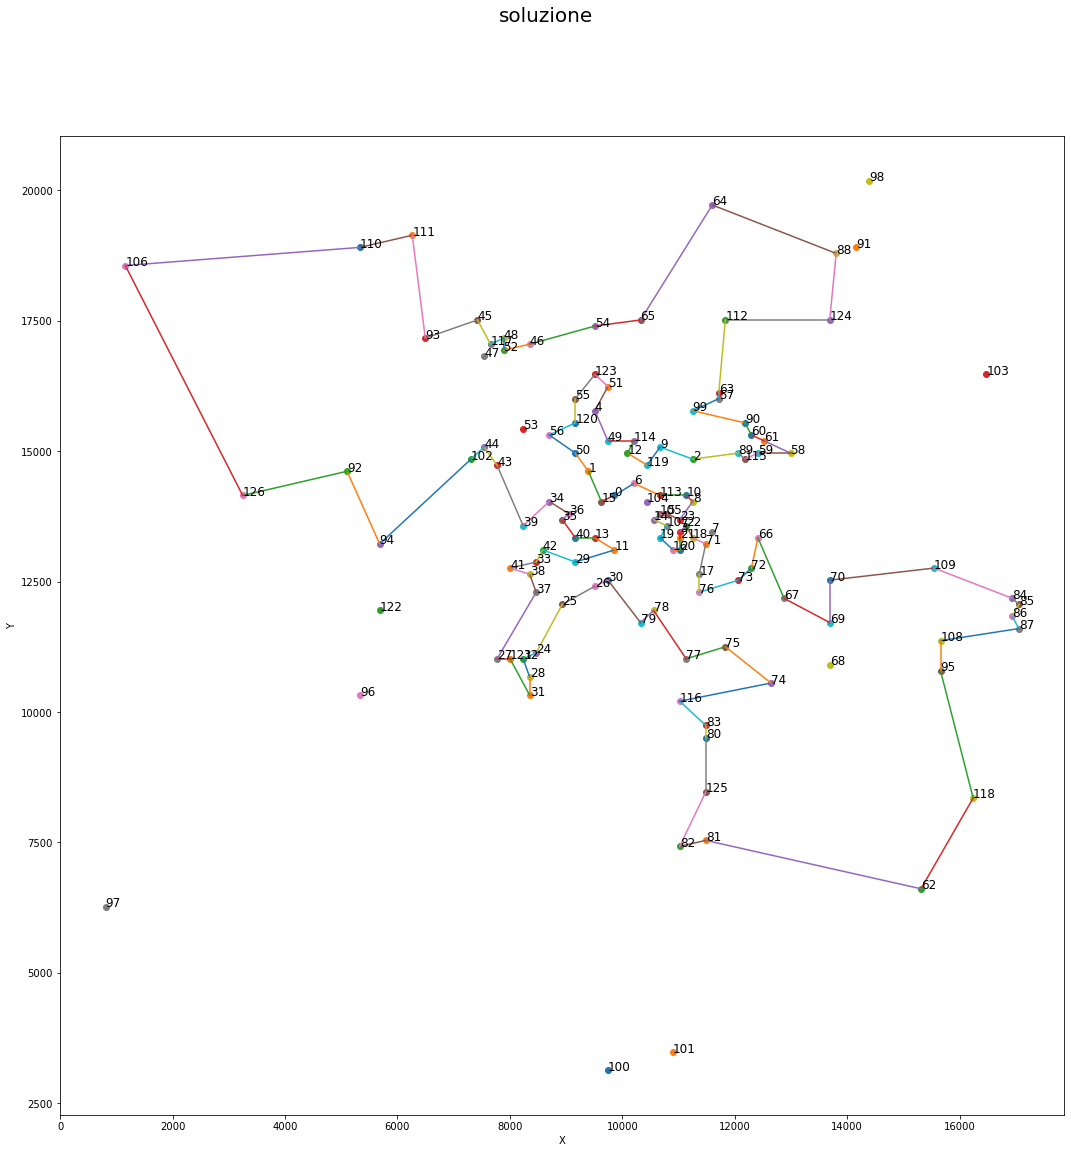

In [21]:
plotTour(bestTour,"soluzione",18)

### Salvataggio soluzione

In [10]:
mod.write("bier127lazy.lp")
mod.write("bier127lazy.sol")

## Euristiche greedy
La funziona getBest è utilizzata dalle euristiche greedy implementate, prende in ingresso 3 parametri tra cui
- T: insieme dei nodi presenti nella soluzione
- funcScore: funzione che associa ad un nodo un indice, ogni euristica specifica la sua metrica
- checkValid: funzione per valutare se una generica soluzione parziale è valida

getBest ricava la lista dei nodi esterni alla soluzione parziale, elimina i nodi che aggiunti alla soluzione parziale la renderebbero non valida (>=TMAX), assegna ad ogni nodo valido un indice tramite funcScore e restituisce il miglior nodo candidato

In [11]:
def getBest(T, funcScore, checkValid):
    validNodes = list(set(list(range(NNodes)))-set(T)) #calcolo nodi esterni
    validNodes = list(filter(checkValid, validNodes)) #rimuovo i nodi che sforano TMAX
    #se non ci sono nodi validi, termina
    if len(validNodes)==0:
        return None
    #crea una lista fatta di coppie [(Nodo,valoreIndice),(Nodo,valoreIndice),()...]
    ordNodes = list(zip(validNodes, [funcScore(i,T) for i in validNodes])) 
    bestNode = max(ordNodes,key=lambda item:item[1])[0] #estrae il nodo con il nodo migliore e lo restituisce
    return bestNode

greedyOut = []

### Alg1
In questa prima euristica partendo dal nodo origine, si valuta la lista dei nodi non presenti nel tour, vengono eliminati i nodi che non rispettano il vincolo temporale del problema. Infine per ogni nodo viene valutato l'indice ottenuto dal rapporto tra la score del nodo e la distanza dall'ultimo nodo attuale del tour, si ordinano i nodi in ordine decrescente in funzione dell'indice calcolato (scelta greedy) e si prende il primo nodo della lista se essa non è vuota

Time: 89968.3294424693
Score: 26035
gap(15.689767%)
[0, 15, 36, 35, 34, 43, 44, 102, 38, 33, 42, 41, 25, 24, 32, 121, 27, 28, 31, 78, 79, 16, 20, 19, 22, 23, 8, 10, 113, 105, 5, 107, 3, 71, 17, 76, 11, 30, 26, 29, 13, 12, 114, 9, 63, 57, 99, 115, 59, 61, 60, 90, 112, 64, 123, 51, 120, 50, 1, 6, 119, 2, 66, 67, 70, 74, 77, 116, 83, 80, 82, 81, 62, 118, 95, 108, 84, 85, 86, 87, 101, 100, 18, 21, 14]


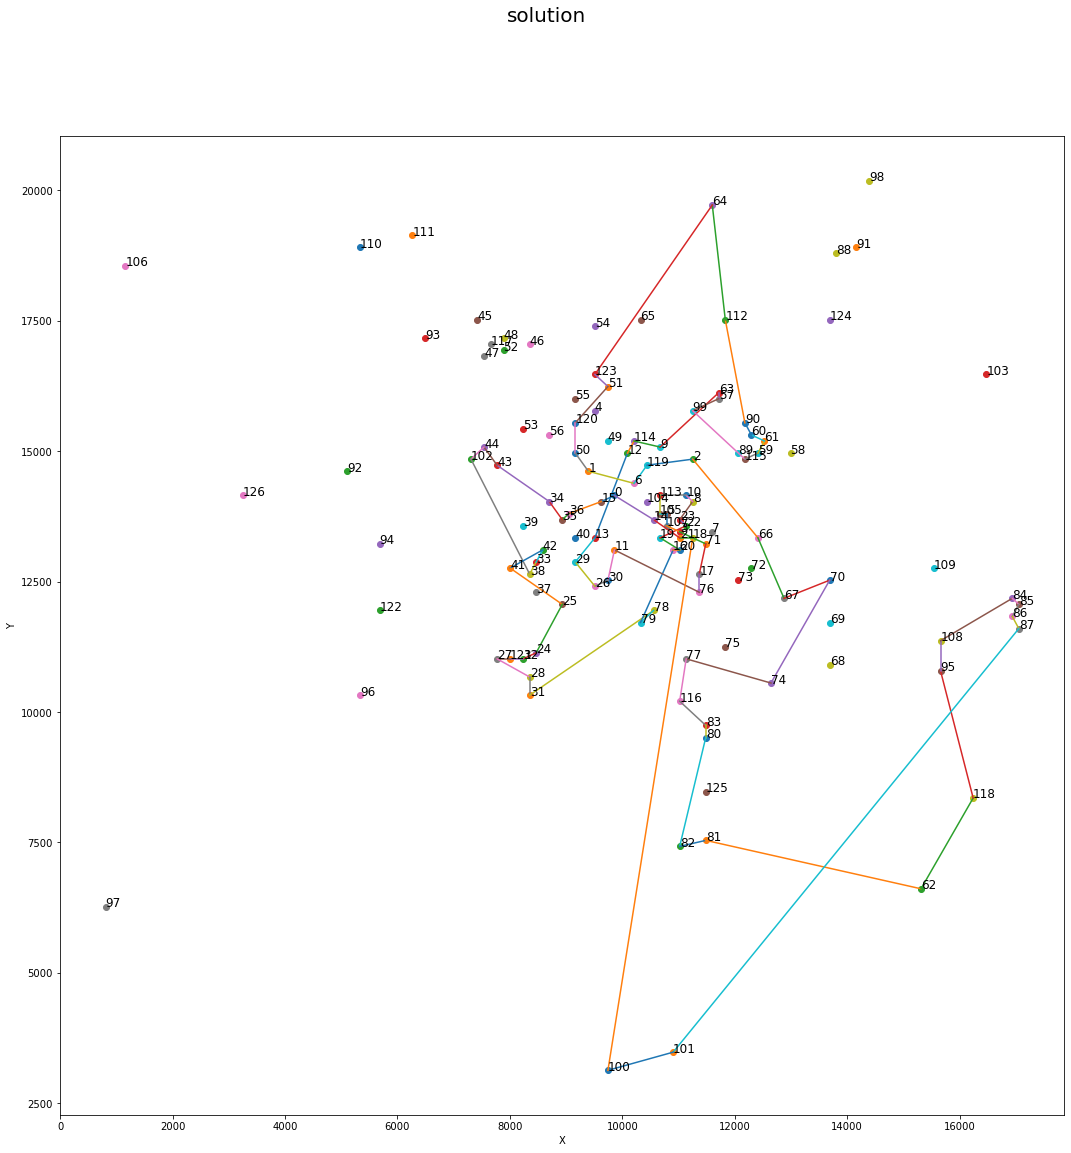

In [12]:
Tour1 = [0]

#calcola il tempo residuo 
#TMAX - tempo del percorso attuale
def getTimeLeft(T):
    N = len(T)
    c = 0
    for i in range(N-1):
        c = c + Dist[ ( T[i], T[i+1] ) ]
    return TMAX-c

#ad ogni nodo i è assegnato un indice pari
#al rapporto tra score e distanza tra il nodo i
#e l'ultimo nodo di T
def funcScore1(i,T):
    return score[i]/Dist[(T[-1],i)]

#se aggiungo x come prossimo nodo
#la distanza last->x->origine, rientra nel tempo rimanente?
def isValid1(x):
    return Dist[(Tour1[-1], x)] + Dist[(x,0)] <= getTimeLeft(Tour1)

while True:
    nextNode = getBest(Tour1,funcScore1,isValid1)
    if nextNode is None:
        break
    Tour1.append(nextNode)
    
gap =  float((bestScore-calcScore(Tour1))*(100/bestScore))
print("Time:",calcTime(Tour1))
print("Score:",calcScore(Tour1))
print("gap(%f%%)" % ( gap ) )
print(Tour1)
greedyOut.append((calcScore(Tour1),gap))
plotTour(Tour1,"solution",18)



### Alg2
Utilizza solo la distanza per la scelta

Time: 89209.79360843397
Score: 28099
gap(9.005829%)
[0, 15, 1, 50, 56, 53, 44, 102, 43, 34, 35, 36, 40, 13, 11, 30, 26, 29, 42, 33, 38, 37, 25, 24, 32, 121, 27, 28, 31, 79, 78, 76, 17, 20, 16, 21, 3, 22, 23, 5, 105, 14, 107, 19, 18, 71, 7, 8, 10, 113, 104, 6, 119, 9, 114, 12, 49, 4, 55, 120, 51, 123, 54, 65, 112, 63, 57, 99, 2, 89, 115, 59, 61, 60, 90, 58, 66, 72, 73, 67, 70, 69, 68, 74, 75, 77, 116, 83, 80, 125, 81, 82, 101, 100, 62, 118, 95, 108, 86, 85, 84, 87, 109, 103, 124, 88, 91, 98, 64]


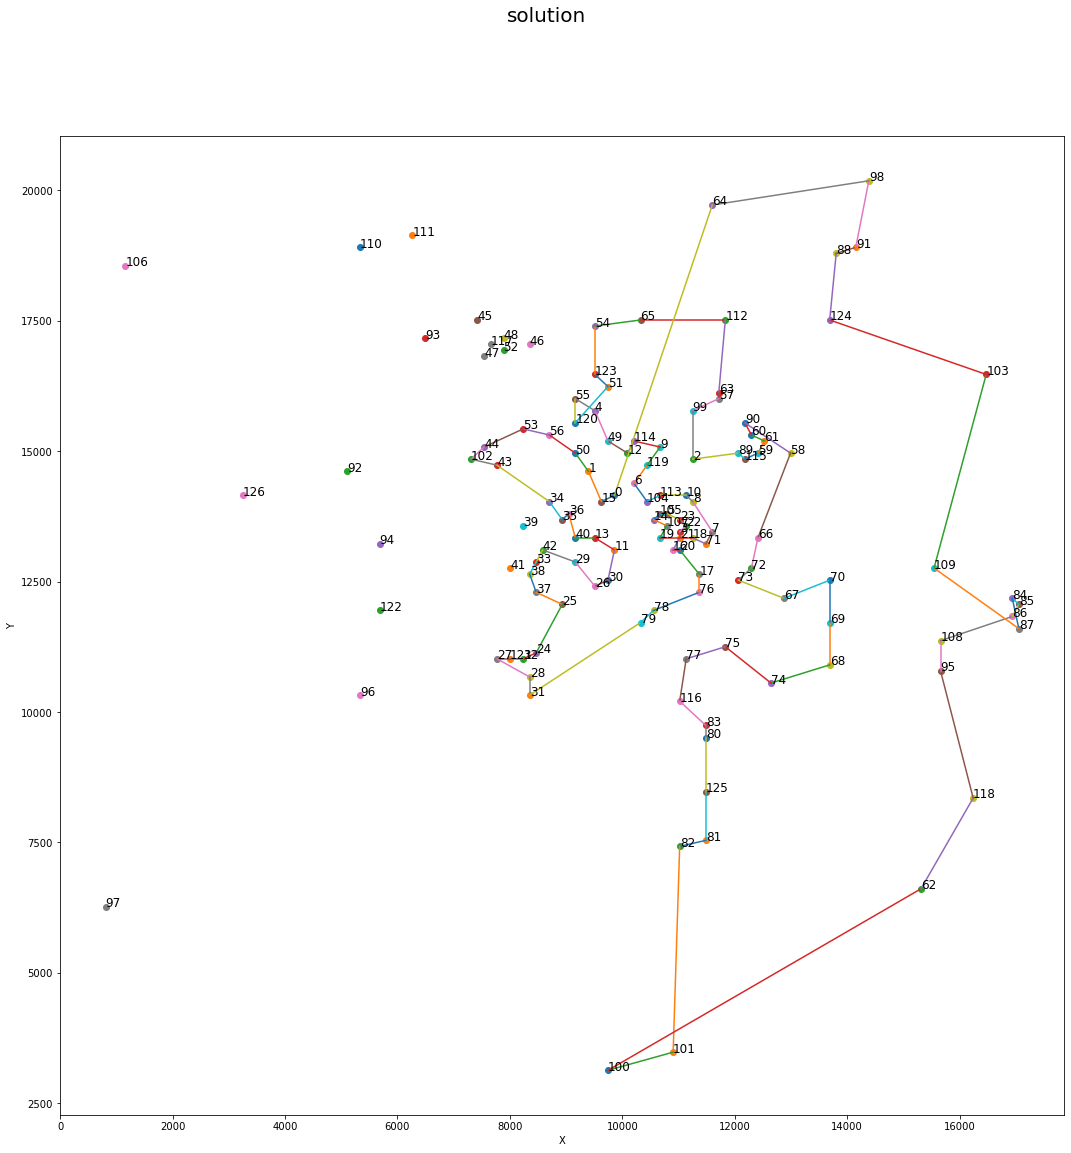

In [13]:
Tour2 = [0]
def funcScore2(i,T):
    return 1/Dist[(T[-1],i)]
def isValid2(x):
    return Dist[(Tour2[-1], x)] + Dist[(x,0)] <= getTimeLeft(Tour2)
def funcScore3(i,T):
    return score[i]
while True:
    nextNode = getBest(Tour2, funcScore2, isValid2)
    if nextNode is None:
        break
    Tour2.append(nextNode)
gap =  float((bestScore-calcScore(Tour2))*(100/bestScore))
print("Time:",calcTime(Tour2))
print("Score:",calcScore(Tour2))
print("gap(%f%%)" % ( gap ) )
print(Tour2)
greedyOut.append((calcScore(Tour2),gap))
plotTour(Tour2,"solution",18)


### Alg3
Utilizza solo lo score per la scelta

Time: 89923.58349832638
Score: 10950
gap(64.540155%)
[0, 38, 16, 123, 8, 28, 82, 24, 63, 31, 62, 74, 27, 43, 78, 22, 34, 126, 121, 11, 51, 59, 9, 114, 12]


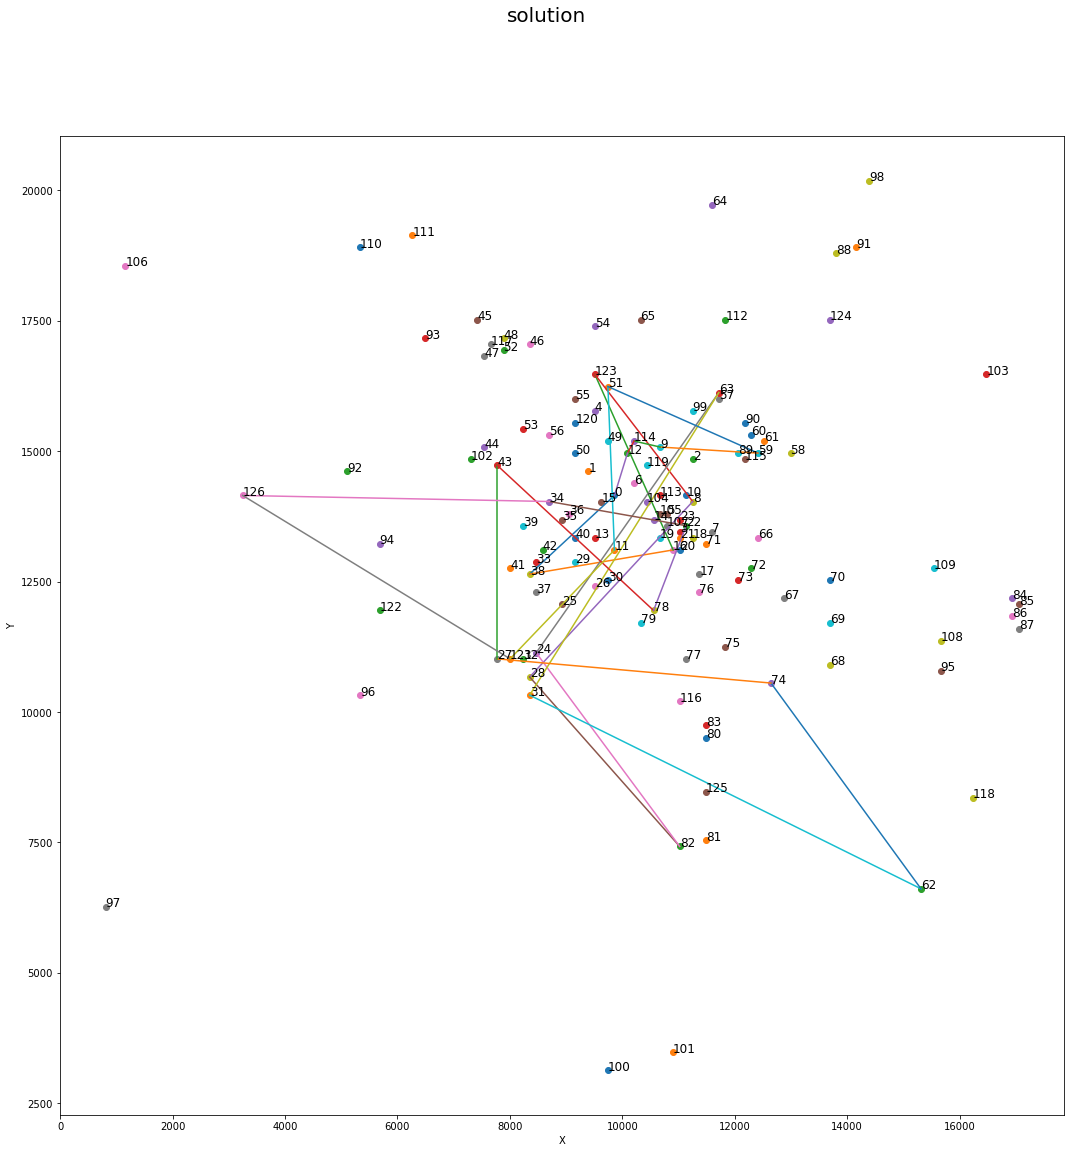

In [14]:
Tour3 = [0]
def funcScore3(i,T):
    return score[i]
def isValid3(x):
    return Dist[(Tour3[-1], x)] + Dist[(x,0)] <= getTimeLeft(Tour3)

while True:
    nextNode = getBest(Tour3, funcScore3, isValid3)
    if nextNode is None:
        break
    Tour3.append(nextNode)
gap =  float((bestScore-calcScore(Tour3))*(100/bestScore))
print("Time:",calcTime(Tour3))
print("Score:",calcScore(Tour3))
print("gap(%f%%)" % ( gap ) )
print(Tour3)
greedyOut.append((calcScore(Tour3),gap))
plotTour(Tour3,"solution",18)

## Ricerca locale
Un problema degli approcci greedy e che prendono decisioni solamente in base allo stato successivo, ad esempio selezionare il prossimo nodo in base alla distanza minima oppure al massimo punteggio, può portarci in situazioni di stallo, infatti con questo approccio nelle ultime iterazioni dell'algoritmo siamo costretti a prendere i nodi rimanenti anche se non ottimi.

In [57]:
import itertools

#list(itertools.permutations(s, n)) 
#ha ripetizioni [1,2,3] -> [1,2],[1,3],[2,1],[2,3],[3,2]...

#valuta quale coppia di nodi interni al Tour T
#scambiare con una coppia di nodi esterni
def evalComb(T, comb, seq, pairT): 
    res = list() #lista dei possibili scambi conveniente e validi
    newT = T[:] #copia del Tour
    #comb è la lista del prodotto cartesiano tra gli indici
    #della lista seq(nodi esterni) e pairT(nodi interni)
    #quindi enumera tutti i possibili scambi
    for a,b in comb: #a indice del vettore seq, b indice vettore pairT
        new = seq[a] #coppia nodi da inserire
        old = pairT[b] #coppia nodi da rimuovere
        oldScore =  calcScore(newT)
        oldTime  =  calcTime(newT)
        #possiamo fare cosi la sostituzione dato che per ogni nodo è presente una sola volta nel tour
        n = len(new)
        #sostituiamo old con new
        for i in range(0,n):
            newT[newT.index(old[i])] = new[i]
        #calcolo parametri del nuovo tour
        newScore =  calcScore(newT)
        newTime  =  calcTime(newT)
        #se lo scambio è conveniente ed è valido
        if (newScore/newTime)>(oldScore/oldTime) and newTime<=TMAX:
            #aggiungo lo scambio alla lista dei possibili
            res.append((newScore,newTime, new, old))
        #ripristino il tour originale, per usarlo nelle prossi
        for i in range(0,n):
            newT[newT.index(new[i])] = old[i]
        
    return res

#calcola i possibili scambi tra sequenze di k nodi interni e k nodi esterni
def optIntExt(T,k):
    validNodes = list(set(list(range(NNodes)))-set(T)) #calcolo nodi esterni  
    seq = list(itertools.permutations(validNodes, k))#tutte le possibili coppie di nodi esterni
    #pairT = [(T[i],T[i+1]) for i in range(1,len(T)-1)] #coppie di nodi contigui sul percorso
    pairT = list(itertools.permutations(T[1:], k))#tutte le possibili coppie di nodi interni
    #comb è il prodotto cartesiano tra gli indici della lista seq
    #e della lista pairT, enumera tutti i possibili scambi
    comb = [(a,b) for a,b in itertools.product(list(range(0,len(seq))),list(range(0,len(pairT))))]
    #ho calcolato l'intorno di scambio nodi esterni-interni
    res = evalComb(T,comb,seq,pairT) #valuto i punti dell'intorno
    return res

#scambio L'ordine dei nodi interni
#cercando di abbassare il tempo impiegato
def optIntInt(T):
    #lista dei possibili scambi tra due nodi interni
    #([1,2,3],2) -> [(1, 2), (1, 3), (2, 3)]
    validSwap = list(itertools.combinations(T[1:], 2))
    time = calcTime(T) #tempo del tour attuale
    newT = T[:]
    cI, cJ = -1,-1
    for i,j in validSwap: #itero su tutti gli scambi possibili
        indI = newT.index(i)
        indJ = newT.index(j)
        newT[indI] = j
        newT[indJ] = i
        newTime = calcTime(newT) #tempo del tour dopo lo scambio
        newT[indI] = i #resetto
        newT[indJ] = j
        
        #se lo scambio migliora il tempo
        #rispetto allo scambio precedente
        if newTime<time: 
            #newTime = time
            time = newTime
            cI = indI
            cJ = indJ
            
    #restituisco gli indici da scambiare
    return cI,cJ
            
def tryAdd(T):
    time = calcTime(T)
    if time<TMAX: #se posso aggiungere qualcosa
        validNodes = list(set(list(range(NNodes)))-set(T)) #calcolo nodi esterni  
        #ogni nodo eserno posso inserirlo dopo un nodo già nel percorso, devo capire dove
        comb = [(a,b) for a,b in itertools.product(T,validNodes)] #combinazioni di aggiunte
        #[..a,c..] ->  [..a,b,c..]
        newT = T[:]
        nI,nJ, nScore = -1,-1,-1
        #itero sui possibili inserimenti del nodo j come successivo del nodo i
        for i,j in comb:
            cI = newT.index(i) 
            newT.insert(cI+1, j) #inserisco dopo il nodo i il nodo j
            newTime = calcTime(newT)
            newScore = calcScore(newT)
            #se l'inserimento è valido e conveniente rispetto
            #all'inserimento precedente
            if newTime<=TMAX and newScore>nScore:
                nI,nJ,nScore = cI+1,j,newScore
            newT.remove(j)
            
        return nI,nJ,nScore
    return -1,-1,-1





In [73]:
optOut = []
def localSearch(tourToOpt, count = 60, p = 1, showOutput = False):
    
    newT = tourToOpt[:]
    oldT = newT[:]
    
    while count>=0:
        mossa = list()

        #provo a scambiare p nodi interni con p esterni
        res = optIntExt(newT,p)
        if len(res) >= 1: #se esiste uno scambio possibile
            m = max(res,key=lambda item:item[0]) #prendi il migliore
            #(newScore,newTime,new,old)
            new = m[2] #(nodo1,..,nodop) i nodi che entrano
            old = m[3] #(nodo1,..,nodop) i nodi che escono
            oldS = ", ".join(str(n) for n in old) 
            newS = ",".join(str(n) for n in new) 
            n = len(new) #quanti nodi devo sostituire
            #sostituisco i p nodi vecchi con i p nuovi
            for i in range(0,n):
                newT[newT.index(old[i])] = new[i]
            mossa.append("INTEXT (%s) -> (%s)" % (oldS,newS))

        #provo ad aggiungere un nodo esterno
        K = tryAdd(newT) #K = (cI+1,j,newScore) = dove inserire, cosa inserire, score nuovo
        if K[0] != -1 and K[1] != -1:
            newT.insert(K[0],K[1])
            mossa.append("ADD (%d -> %d)" % (newT[K[0]-1],K[1]))
            
        #provo ad invertire un nodo interno con un altro interno
        #(cerco di migliorare il costo del cammino già esistente)
        cI,cJ = optIntInt(newT)
        if cI != -1 and cJ != -1: 
            newT[cI], newT[cJ] = newT[cJ], newT[cI]
            mossa.append("INTINT (%d) <-> (%d)" % (newT[cJ],newT[cI]))
            
        if len(mossa)==0: #non ci sono state modifiche
            break
        if showOutput:
            print("----------------------------------------")
            print(", ".join(mossa))
            print("Actual score: %f, Actual time: %f, NNodes: %d" % (calcScore(newT),calcTime(newT),len(newT)))
            print(newT)
        count = count - 1
        
    return (newT,count)
import time
def localOpt(Tour,maxIteraz, p=1, showOutput=False, showPlot = False):
    oldScore = calcScore(Tour)
    print("BEST:  score(%f), time(%f), nnodes(%d)" % (bestScore,calcTime(bestTour),len(bestTour)))
    print("START: score(%f), time(%f), nnodes(%d)" % (oldScore,calcTime(Tour),len(Tour)))
    print("TOUR: ",Tour)
    start_time = time.time()
    optTour,k = localSearch(Tour,maxIteraz,p, showOutput)
    newScore = calcScore(optTour)
    print("\n\noptTour:",optTour)
    print("END:   score(%f), time(%f), nnodes(%d)" % (newScore,calcTime(optTour),len(optTour)))
    print("\t%d iteration, %s seconds" % (maxIteraz-k,time.time() - start_time))
    oldGap = float((bestScore-oldScore)*(100/bestScore))
    newGap = float((bestScore-newScore)*(100/bestScore))
    print("\told gap(%f%%), new gap(%f%%)" % ( oldGap, newGap ) )
    optOut.append((newScore,newGap))
    if showPlot:
        plotTour(Tour,"old solution",18)
        plotTour(optTour,"new solution",18)

In [74]:
localOpt(Tour1,200,1, showOutput = True)

BEST:  score(30880.000000), time(89934.585609), nnodes(114)
START: score(26035.000000), time(89968.329442), nnodes(85)
TOUR:  [0, 15, 36, 35, 34, 43, 44, 102, 38, 33, 42, 41, 25, 24, 32, 121, 27, 28, 31, 78, 79, 16, 20, 19, 22, 23, 8, 10, 113, 105, 5, 107, 3, 71, 17, 76, 11, 30, 26, 29, 13, 12, 114, 9, 63, 57, 99, 115, 59, 61, 60, 90, 112, 64, 123, 51, 120, 50, 1, 6, 119, 2, 66, 67, 70, 74, 77, 116, 83, 80, 82, 81, 62, 118, 95, 108, 84, 85, 86, 87, 101, 100, 18, 21, 14]
----------------------------------------
INTEXT (100) -> (73), ADD (64 -> 54), INTINT (81) <-> (101)
Actual score: 26385.000000, Actual time: 86438.466455, NNodes: 86
[0, 15, 36, 35, 34, 43, 44, 102, 38, 33, 42, 41, 25, 24, 32, 121, 27, 28, 31, 78, 79, 16, 20, 19, 22, 23, 8, 10, 113, 105, 5, 107, 3, 71, 17, 76, 11, 30, 26, 29, 13, 12, 114, 9, 63, 57, 99, 115, 59, 61, 60, 90, 112, 64, 54, 123, 51, 120, 50, 1, 6, 119, 2, 66, 67, 70, 74, 77, 116, 83, 80, 82, 101, 62, 118, 95, 108, 84, 85, 86, 87, 81, 73, 18, 21, 14]
------

----------------------------------------
INTEXT (4) -> (1), ADD (13 -> 4), INTINT (4) <-> (1)
Actual score: 29222.000000, Actual time: 88452.880740, NNodes: 101
[0, 6, 15, 40, 36, 35, 34, 102, 44, 43, 39, 42, 41, 33, 38, 37, 25, 24, 32, 121, 27, 28, 31, 79, 78, 16, 20, 19, 22, 23, 8, 10, 113, 105, 5, 107, 3, 71, 17, 76, 11, 30, 26, 29, 13, 1, 12, 114, 9, 99, 57, 63, 115, 59, 61, 60, 90, 112, 88, 64, 65, 54, 48, 111, 110, 93, 45, 117, 52, 123, 51, 120, 50, 49, 4, 119, 2, 66, 72, 67, 74, 77, 116, 83, 80, 82, 81, 62, 118, 108, 95, 87, 84, 85, 86, 109, 70, 73, 18, 21, 14]
----------------------------------------
ADD (112 -> 124), INTINT (108) <-> (95)
Actual score: 29330.000000, Actual time: 88473.831954, NNodes: 102
[0, 6, 15, 40, 36, 35, 34, 102, 44, 43, 39, 42, 41, 33, 38, 37, 25, 24, 32, 121, 27, 28, 31, 79, 78, 16, 20, 19, 22, 23, 8, 10, 113, 105, 5, 107, 3, 71, 17, 76, 11, 30, 26, 29, 13, 1, 12, 114, 9, 99, 57, 63, 115, 59, 61, 60, 90, 112, 124, 88, 64, 65, 54, 48, 111, 110, 93, 45, 

----------------------------------------
ADD (69 -> 68), INTINT (57) <-> (63)
Actual score: 29923.000000, Actual time: 89940.707561, NNodes: 114
[0, 6, 15, 40, 35, 36, 34, 56, 53, 44, 102, 43, 39, 42, 33, 41, 38, 37, 25, 24, 32, 121, 27, 28, 31, 79, 78, 16, 20, 21, 22, 23, 8, 10, 113, 105, 5, 107, 3, 18, 17, 76, 11, 30, 26, 29, 13, 1, 12, 114, 9, 99, 63, 57, 89, 115, 59, 58, 61, 60, 90, 112, 124, 88, 64, 65, 54, 46, 48, 47, 93, 110, 111, 45, 117, 52, 123, 51, 4, 55, 120, 50, 49, 119, 2, 66, 72, 67, 69, 68, 74, 75, 77, 116, 83, 80, 125, 82, 81, 62, 118, 95, 108, 87, 86, 85, 84, 109, 70, 73, 71, 19, 14, 104]
----------------------------------------
INTINT (48) <-> (52)
Actual score: 29923.000000, Actual time: 89893.259316, NNodes: 114
[0, 6, 15, 40, 35, 36, 34, 56, 53, 44, 102, 43, 39, 42, 33, 41, 38, 37, 25, 24, 32, 121, 27, 28, 31, 79, 78, 16, 20, 21, 22, 23, 8, 10, 113, 105, 5, 107, 3, 18, 17, 76, 11, 30, 26, 29, 13, 1, 12, 114, 9, 99, 63, 57, 89, 115, 59, 58, 61, 60, 90, 112, 124, 88

In [75]:
localOpt(Tour2,30,1)

BEST:  score(30880.000000), time(89934.585609), nnodes(114)
START: score(28099.000000), time(89209.793608), nnodes(109)
TOUR:  [0, 15, 1, 50, 56, 53, 44, 102, 43, 34, 35, 36, 40, 13, 11, 30, 26, 29, 42, 33, 38, 37, 25, 24, 32, 121, 27, 28, 31, 79, 78, 76, 17, 20, 16, 21, 3, 22, 23, 5, 105, 14, 107, 19, 18, 71, 7, 8, 10, 113, 104, 6, 119, 9, 114, 12, 49, 4, 55, 120, 51, 123, 54, 65, 112, 63, 57, 99, 2, 89, 115, 59, 61, 60, 90, 58, 66, 72, 73, 67, 70, 69, 68, 74, 75, 77, 116, 83, 80, 125, 81, 82, 101, 100, 62, 118, 95, 108, 86, 85, 84, 87, 109, 103, 124, 88, 91, 98, 64]


optTour: [0, 15, 1, 50, 56, 53, 44, 102, 43, 39, 34, 36, 35, 40, 13, 11, 30, 26, 29, 42, 33, 41, 38, 37, 25, 24, 32, 121, 27, 28, 31, 79, 78, 76, 17, 20, 16, 21, 3, 22, 23, 5, 105, 14, 107, 19, 18, 71, 7, 8, 10, 113, 104, 6, 119, 9, 114, 12, 49, 120, 55, 4, 51, 123, 54, 65, 112, 63, 57, 99, 2, 89, 115, 59, 60, 90, 61, 58, 66, 72, 73, 67, 70, 69, 68, 74, 75, 77, 116, 83, 80, 125, 81, 82, 100, 101, 62, 118, 95, 108, 87, 8

BEST:  score(30880.000000), time(89934.585609), nnodes(114)
START: score(10950.000000), time(89923.583498), nnodes(25)
TOUR:  [0, 38, 16, 123, 8, 28, 82, 24, 63, 31, 62, 74, 27, 43, 78, 22, 34, 126, 121, 11, 51, 59, 9, 114, 12]


optTour: [0, 6, 119, 15, 36, 35, 40, 13, 11, 19, 16, 21, 3, 107, 14, 105, 5, 10, 8, 23, 22, 18, 71, 17, 20, 30, 26, 78, 76, 73, 72, 66, 58, 61, 60, 90, 99, 57, 63, 112, 88, 64, 65, 54, 46, 48, 52, 117, 45, 111, 110, 93, 44, 43, 41, 38, 33, 42, 39, 34, 50, 56, 120, 4, 123, 51, 49, 1, 37, 24, 28, 32, 121, 27, 31, 116, 83, 80, 125, 82, 81, 62, 118, 95, 108, 87, 86, 85, 84, 109, 70, 67, 74, 75, 77, 79, 25, 29, 104, 113, 115, 59, 89, 2, 9, 114, 12]
END:   score(29517.000000), time(89774.061198), nnodes(107)
	82 iteration, 36.296013832092285 seconds
	old gap(64.540155%), new gap(4.413860%)


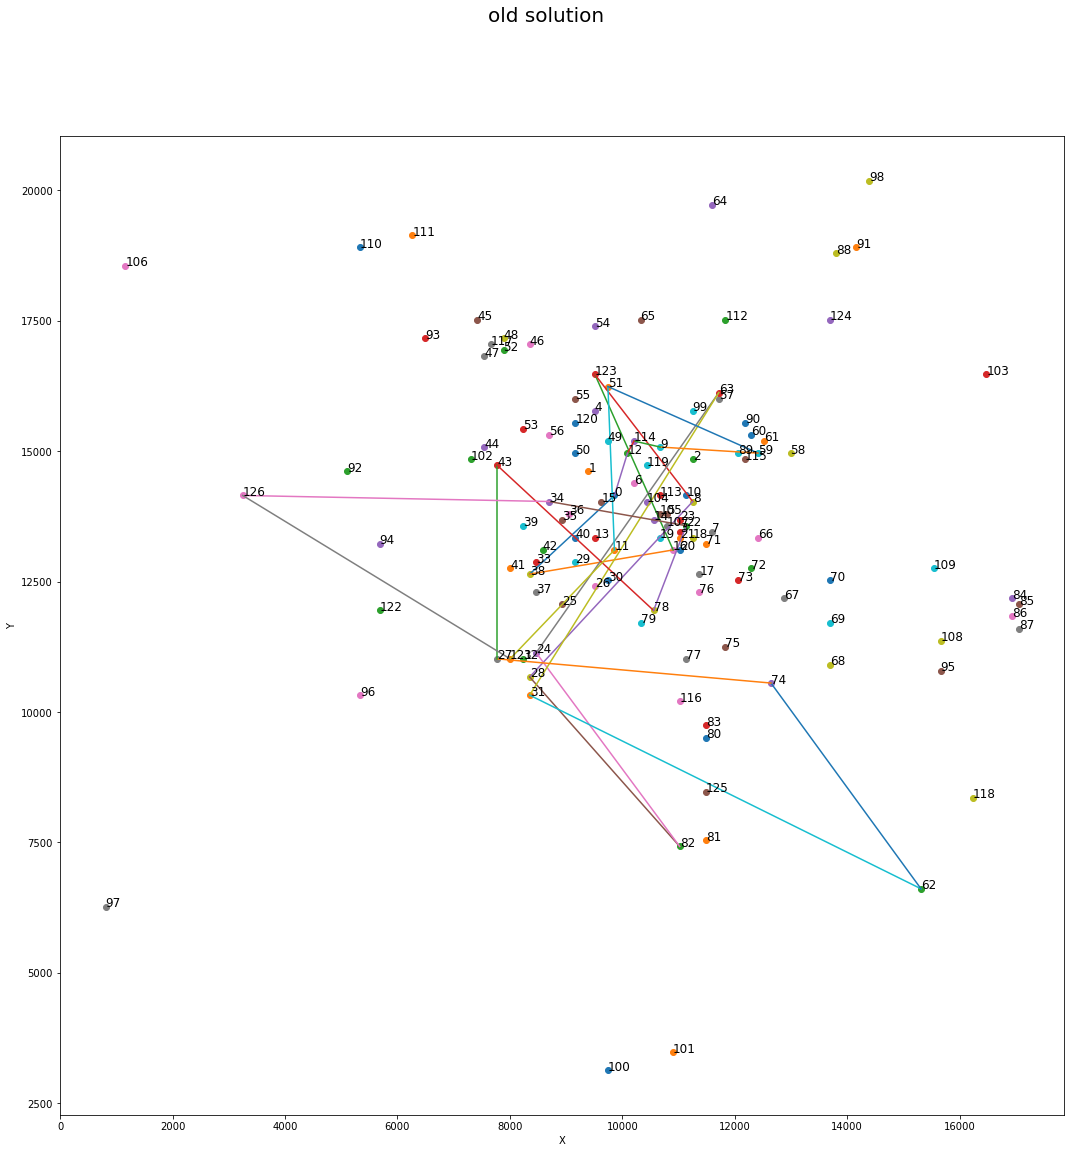

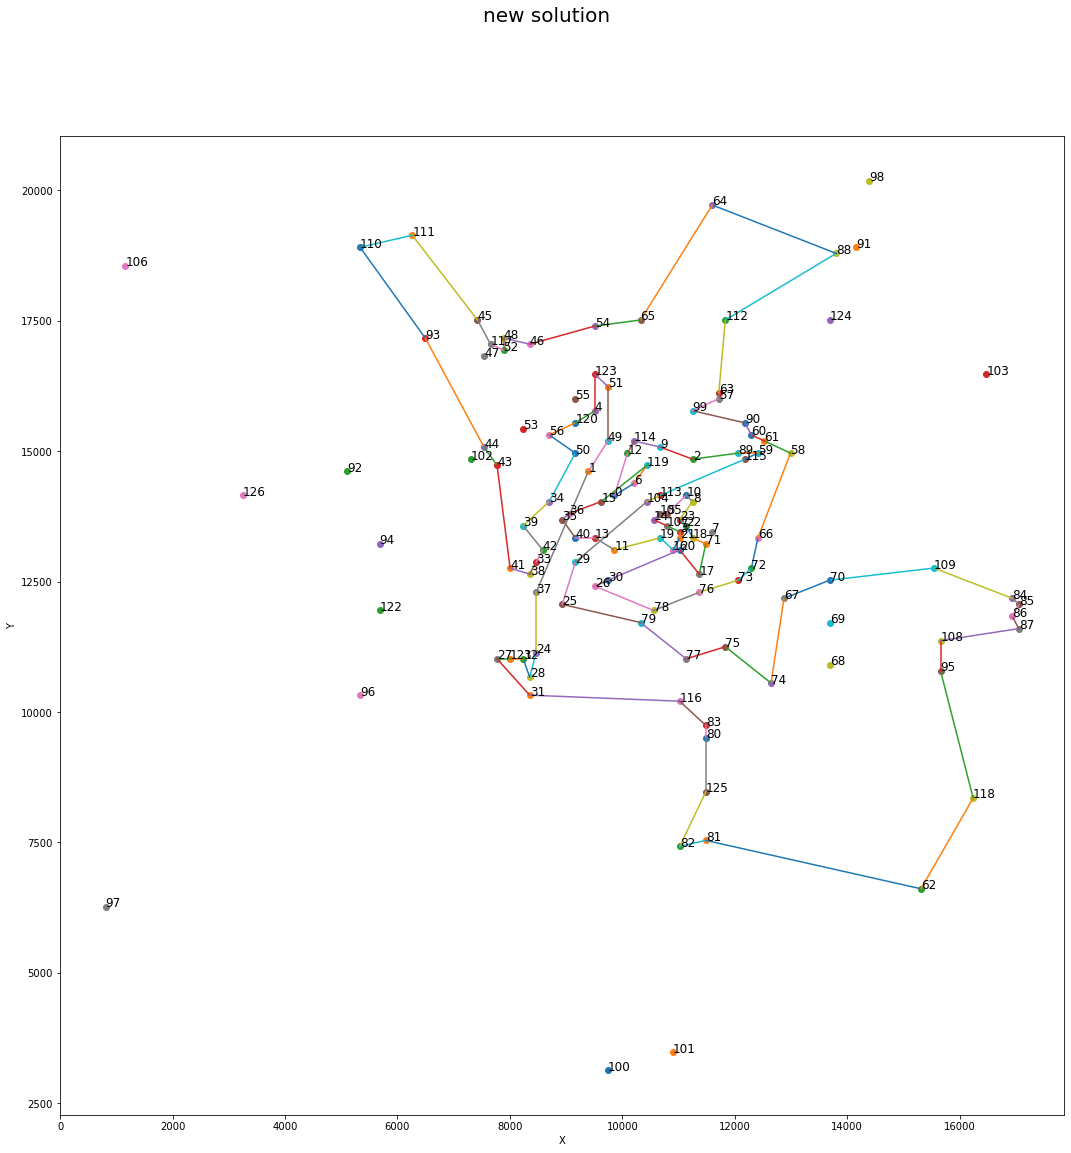

In [76]:
localOpt(Tour3,200,1,showPlot=True)

In [79]:
print("Best: %f\n"%(bestScore))
for i in range(3):
    print("Euristica ",i+1)
    print("Greedy: score %f, gap %f %%"%(greedyOut[i][0], greedyOut[i][1]))
    print("Search: score %f, gap %f %%"%(optOut[i][0], optOut[i][1]))
    print("\n")

Best: 30880.000000

Euristica  1
Greedy: score 26035.000000, gap 15.689767 %
Search: score 29923.000000, gap 3.099093 %


Euristica  2
Greedy: score 28099.000000, gap 9.005829 %
Search: score 28582.000000, gap 7.441710 %


Euristica  3
Greedy: score 10950.000000, gap 64.540155 %
Search: score 29517.000000, gap 4.413860 %


